<a href="https://colab.research.google.com/github/swetha2712/Plant-Disease-Detection/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramya1207","key":"8ed1b2016afa60a955063d061e02701e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

 97% 641M/658M [00:07<00:00, 109MB/s] 
100% 658M/658M [00:07<00:00, 96.9MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "plantdisease.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!pip install -q keras

In [ ]:
import keras

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from PIL import Image
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import cv2
import os
from os import listdir
from sklearn.utils import shuffle
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint
import numpy as np
import pickle
import cv2
from os import listdir
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import pandas as pd
import PIL
from PIL import Image
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import os
from sklearn.utils import shuffle
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU 
from keras.utils.vis_utils import plot_model
from numpy import ones 
from numpy import zeros 
from numpy.random import rand 
from numpy.random import randint
from keras.layers import Reshape
from keras.layers import Conv2DTranspose 
import pickle
import tensorflow as tf
from numpy.random import randn 
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


In [ ]:
directory_root = '/content/PlantVillage'
print(len(listdir(directory_root)))

15


In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
                
        for single_plant_disease_image in plant_disease_folder_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_folder_list.remove(single_plant_disease_image)

        for image in plant_disease_folder_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(image_directory)
                label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [ ]:
img_info = pd.DataFrame({'image_path':image_list,'label':label_list})
print(img_info.head())
print(len(img_info))

                                          image_path             label
0  /content/PlantVillage/Tomato_Leaf_Mold/39feab4...  Tomato_Leaf_Mold
1  /content/PlantVillage/Tomato_Leaf_Mold/1b35b99...  Tomato_Leaf_Mold
2  /content/PlantVillage/Tomato_Leaf_Mold/56f9744...  Tomato_Leaf_Mold
3  /content/PlantVillage/Tomato_Leaf_Mold/697ae68...  Tomato_Leaf_Mold
4  /content/PlantVillage/Tomato_Leaf_Mold/4797e35...  Tomato_Leaf_Mold
20636


In [ ]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("label")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()

,image_path,label,labels_integer
20631,/content/PlantVillage/Potato___healthy/1106c3f...,Potato___healthy,14
20632,/content/PlantVillage/Potato___healthy/c9ad5c9...,Potato___healthy,14
20633,/content/PlantVillage/Potato___healthy/762672f...,Potato___healthy,14
20634,/content/PlantVillage/Potato___healthy/4bbccfb...,Potato___healthy,14
20635,/content/PlantVillage/Potato___healthy/a4d1d8c...,Potato___healthy,14


In [ ]:
img_info = shuffle(img_info)
list_vectors = []


In [ ]:
for image_path in img_info.image_path:
    #read as rgb array
    img = Image.open(image_path)
    size = (32, 32)
    img = img.resize(size, PIL.Image.ANTIALIAS)  
    img_array = np.array(img)
    #append image vector to list
    list_vectors.append(img_array)
    
print(len(list_vectors))

20636


In [ ]:
X = np.stack((list_vectors))
Y =  img_info['labels_integer']
print(X.shape)


(20636, 32, 32, 3)


In [ ]:
X = X/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=15)
print(Y.shape, Y_one_hot.shape)


(20636,) (20636, 15)


In [ ]:
np.savez("x_images_arrayscnn", X)
np.savez("y_numeric_labelscnn", Y_one_hot)


In [ ]:
x_npz = np.load("x_images_arrayscnn.npz")
X = x_npz['arr_0']


In [ ]:
y_npz = np.load("y_numeric_labelscnn.npz")
Y_one_hot = y_npz['arr_0']


In [ ]:
print(X.shape)


(20636, 32, 32, 3)


In [ ]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))


In [ ]:
X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]


In [ ]:
Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:index_val]
Y_test = Y_one_hot[index_val:]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)


(16508, 32, 32, 3) (2064, 32, 32, 3) (2064, 32, 32, 3) (16508, 15) (2064, 15) (2064, 15)


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)



In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
num_classes = 15


In [ ]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")




In [ ]:
# define the standalone discriminator model 
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  #Normal
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape)) 
  model.add(LeakyReLU(alpha=0.2))
  #Downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #Downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #Downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #classifier
  model.add(Flatten()) 
  model.add(Dropout(0.4)) 
  model.add(Dense(1, activation='sigmoid')) 
  #compile model
  opt = Adam(lr=0.0002, beta_1=0.5) 
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
  return model


In [ ]:
# define model 
model = define_discriminator() 
# summarize the model 
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

In [ ]:
# define the standalone generator model 
def define_generator(latent_dim): 
  model = Sequential() 
  # foundation for 4x4 image 
  n_nodes = 256 * 4 * 4 
  model.add(Dense(n_nodes, input_dim=latent_dim)) 
  model.add(LeakyReLU(alpha=0.2)) 
  model.add(Reshape((4, 4, 256))) 
  # upsample to 8x8 
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(LeakyReLU(alpha=0.2)) 
  # upsample to 16x16 
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32 
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2)) 
  # output layer 
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same')) 
  return model
  model.add(Conv2D(128, padding="same", kernel_size=3))


In [ ]:
# define the size of the latent space 
latent_dim = 100 
# define the generator model 
model = define_generator(latent_dim) 
# summarize the model 
model.summary() 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)      

In [ ]:
def define_gan(g_model, d_model): 
  # make weights in the discriminator not trainable 
  d_model.trainable = False 
  # connect them 
  model = Sequential() 
  # add generator 
  model.add(g_model) 
  # add the discriminator 
  model.add(d_model) 
  # compile model 
  opt = Adam(lr=0.0002, beta_1=0.5) 
  model.compile(loss='binary_crossentropy', optimizer=opt) 
  return model

In [ ]:
# size of the latent space 
latent_dim = 100 
# create the discriminator 
d_model = define_discriminator() 
# create the generator 
g_model = define_generator(latent_dim) 
# create the gan 
gan_model = define_gan(g_model, d_model) 
# summarize gan model 
gan_model.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [ ]:
# load and prepare training images 
def load_real_samples():
  # convert from unsigned ints to floats 
  X = X_train.astype('float32') 
  # scale from [0,255] to [-1,1] 
  X = (X - 127.5) / 127.5 
  return X


In [ ]:
# select real samples 
def generate_real_samples(dataset, n_samples): 
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples) 
  # retrieve selected images 
  X = dataset[ix] 
  # generate 'real' class labels (1)
  y = ones((n_samples, 1)) 
  return X, y


In [ ]:
# generate points in latent space as input for the generator 
def generate_latent_points(latent_dim, n_samples):
   # generate points in the latent space 
   x_input = randn(latent_dim * n_samples) 
   # reshape into a batch of inputs for the network 
   x_input = x_input.reshape(n_samples, latent_dim) 
   return x_input


In [ ]:
# generate n fake samples with class labels 
def generate_fake_samples(g_model, latent_dim, n_samples): 
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples) 
  # predict outputs 
  X = g_model.predict(x_input) 
  # create 'fake' class labels (0) 
  y = zeros((n_samples, 1)) 
  return X, y


In [ ]:
# create and save a plot of generated images 
def save_plot(examples, epoch, n=7): 
  # scale from [-1,1] to [0,1] 
  examples = (examples + 1) / 2.0 
  # plot images 
  for i in range(n * n): 
    # define subplot 
    plt.subplot(n, n, 1 + i) 
    # turn off axis 
    plt.axis('off') 
    # plot raw pixel data 
    plt.imshow(examples[i]) 
  # save plot to file 
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename) 
  plt.close()


In [ ]:
# evaluate the discriminator, plot generated images, save generator model 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150): 
  # prepare real samples 
  X_real, y_real = generate_real_samples(dataset, n_samples) 
  # evaluate discriminator on real examples 
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0) 
  # prepare fake examples 
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples) 
  # evaluate discriminator on fake examples 
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0) 
  # summarize discriminator performance 
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot 
  save_plot(x_fake, epoch) 
  # save the generator model tile file 
  filename = 'generator_model_%03d.h5' % (epoch+1) 
  g_model.save(filename)


In [ ]:
# train the generator and discriminator 
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=128): 
  bat_per_epo = int(dataset.shape[0] / n_batch) 
  half_batch = int(n_batch / 2) 
  # manually enumerate epochs 
  for i in range(n_epochs): 
    # enumerate batches over the training set 
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples 
      X_real, y_real = generate_real_samples(dataset, half_batch) 
      # update discriminator model weights 
      d_loss1, _ = d_model.train_on_batch(X_real, y_real) 
      # generate 'fake' examples 
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights 
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake) 
      # prepare points in latent space as input for the generator 
      X_gan = generate_latent_points(latent_dim, n_batch) 
      # create inverted labels for the fake samples 
      y_gan = ones((n_batch, 1)) 
      # update the generator via the discriminator's error 
      g_loss = gan_model.train_on_batch(X_gan, y_gan) 
      # summarize loss on this batch 
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # evaluate the model performance, sometimes 
    if (i+1) % 10 == 0: 
      summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [ ]:
# size of the latent space 
latent_dim = 100 
# create the discriminator 
d_model = define_discriminator() 
# create the generator 
g_model = define_generator(latent_dim) 
# create the gan 
gan_model = define_gan(g_model, d_model) 
# summarize gan model 
gan_model.summary() 
# load image data 
dataset = load_real_samples() 
# train model 
train(g_model, d_model, gan_model, dataset, latent_dim)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________
>1, 1/128, d1=0.681, d2=0.695 g=0.692
>1, 2/128, d1=0.525, d2=0.697 g=0.690
>1, 3/128, d1=0.391, d2=0.703 g=0.684
>1, 4/128, d1=0.249, d2=0.718 g=0.669
>1, 5/128, d1=0.126, d2=0.749 g=0.641
>1, 6/128, d1=0.066, d2=0.811 g=0.596
>1, 7/128, d1=0.041, d2=0.906 g=0.551
>1, 8/128, d1=0.049, d2=1.010 g=0.528
>1, 9/128, d1=0.086, d2=1.038 g=0.541
>1, 10/128, d1=0.175, d2=1.053 g=0.576
>1, 11/128, d1=0.270, d2=1.004 g=0.618
>1, 12/128, d1=0.359, d2=0.954 g=0.652
>1, 13/128, d1=0.446, d2=0.893 g=0.659
>1

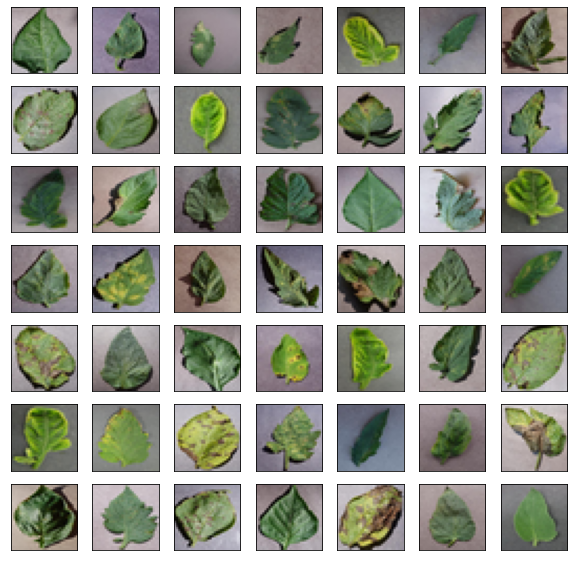

In [ ]:
save_plot(X_train, 1, 7)
plt.figure(figsize=(10,10))
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
width = 32
height = 32
depth = 3
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("sigmoid"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("sigmoid"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("sigmoid"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("sigmoid"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("sigmoid"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("sigmoid"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 64)       

In [ ]:
EPOCHS = 40
INIT_LR = 1e-3
BS = 25

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy","mse"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
from keras.models import Sequential
history = model.fit_generator(aug.flow(X_train, Y_train, batch_size=BS), validation_data=(X_test, Y_test), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS, verbose=1)

Epoch 1/40
660/660 [==============================] - 69s 105ms/step - loss: 0.0468 - accuracy: 0.8691 - mse: 0.0130 - val_loss: 0.1910 - val_accuracy: 0.5320 - val_mse: 0.0470
Epoch 2/40
660/660 [==============================] - 66s 99ms/step - loss: 0.0457 - accuracy: 0.8688 - mse: 0.0127 - val_loss: 0.1345 - val_accuracy: 0.7156 - val_mse: 0.0302
Epoch 3/40
660/660 [==============================] - 65s 99ms/step - loss: 0.0473 - accuracy: 0.8659 - mse: 0.0131 - val_loss: 0.0484 - val_accuracy: 0.8774 - val_mse: 0.0124
Epoch 4/40
660/660 [==============================] - 65s 99ms/step - loss: 0.0444 - accuracy: 0.8711 - mse: 0.0124 - val_loss: 0.0654 - val_accuracy: 0.8299 - val_mse: 0.0167
Epoch 5/40
660/660 [==============================] - 66s 99ms/step - loss: 0.0442 - accuracy: 0.8742 - mse: 0.0123 - val_loss: 0.1282 - val_accuracy: 0.6424 - val_mse: 0.0342
Epoch 6/40
660/660 [==============================] - 66s 99ms/step - loss: 0.0417 - accuracy: 0.8777 - mse: 0.0118 - v

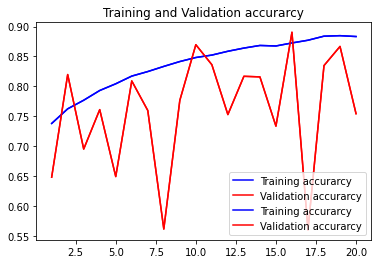

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

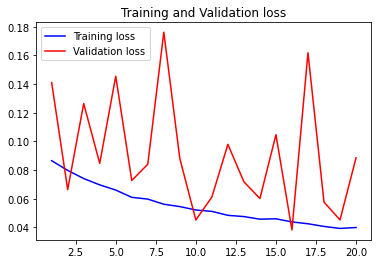

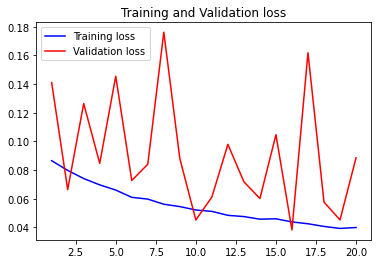

In [ ]:
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
65/65 [==============================] - 2s 28ms/step - loss: 0.0415 - accuracy: 0.8983 - mse: 0.0103
Test Accuracy: 89.82558250427246


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)


In [ ]:
# confusion matrix
values = yhat_classes
n_values = np.max(values) +1
np.eye(n_values)[values]
matrix = multilabel_confusion_matrix(Y_test, np.eye(n_values)[values])
print(matrix)

[[[1949   19]
  [   5   91]]

 [[1890   25]
  [   0  149]]

 [[1874   28]
  [   0  162]]

 [[2014    4]
  [   0   46]]

 [[1873   13]
  [  27  151]]

 [[1860   28]
  [  23  153]]

 [[1953    1]
  [  25   85]]

 [[1913   10]
  [  32  109]]

 [[1880    0]
  [  47  137]]

 [[1945   13]
  [   5  101]]

 [[1951   14]
  [   0   99]]

 [[1928   40]
  [   4   92]]

 [[1742   10]
  [   0  312]]

 [[1866    4]
  [  32  162]]

 [[2048    1]
  [  10    5]]]


In [ ]:
values = yhat_classes
n_values = np.max(values) +1
np.eye(n_values)[values]
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        np.eye(n_values)[values][:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], np.eye(n_values)[values][:, i])


In [ ]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    np.eye(n_values)[values].ravel())
average_precision["micro"] = average_precision_score(Y_test, np.eye(n_values)[values],
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))



Average precision score, micro-averaged over all classes: 0.81


In [ ]:
# recall:
print("Recall averaged over all classes = ",recall_score(Y_test, np.eye(n_values)[values], average='micro'))


Recall averaged over all classes =  0.8982558139534884


In [ ]:
!pip install nbconvert